In [3]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
import glob
from scipy.stats import pearsonr
from tqdm import tqdm

tag = "29_sept"
pheno_cols = ["ADP"]

In [4]:
gws = []
#for c in tqdm(pheno_cols):
for c in tqdm(pheno_cols):
    gw = pd.read_csv("%s/%s/bolt_res_feb_%s" % (export_folder,tag,c),sep="\t")
    gw["pheno"] = c
    gw.P_BOLT_LMM = gw.P_BOLT_LMM.astype(float)
    gws.append(gw)
gw = pd.concat(gws,axis=0,copy=False)
gw.rename(columns={"P_BOLT_LMM":"P"},inplace=True)
# Compute G-wide position
gw["POS"] = gw["BP"]
for ch in range(1,23):
    gw.loc[gw.CHR > ch,"POS"] += gw.loc[gw.CHR == ch,"BP"].max()
gw_ = gw.loc[gw.P < 1e-3]


100%|██████████| 1/1 [00:18<00:00, 18.22s/it]


In [5]:
UKBB_SNPS = []
for chrom in tqdm(range(1,23)):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])

gw_["IN_UKBB"] = gw_.SNP.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())


100%|██████████| 22/22 [02:09<00:00,  5.90s/it]


93095623
['rs367896724', 'rs540431307', 'rs201106462', 'rs548419688', 'rs568405545', 'rs534229142', 'rs537182016', 'rs572818783', 'rs538322974', '1:10616_CCGCCGTTGCAAAGGCGCGCCG_C']
0.9110587310940876


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [6]:
pfc_files = glob.glob("/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/*.tsv")

In [7]:
pfc_files

['/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/TRAP.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/ADP_FIB_ONLY.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/PAR4.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/PAR1.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/ADP_META.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/ADP_PAIR.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/REST.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/CRP.tsv']

In [8]:
gw_pfcs = []
for f in tqdm(pfc_files):
    if "ADP" not in f: continue
    gw_pfc = pd.read_csv(f,sep="\t").rename(columns={"POS":"BP"})
    gw_pfc["POS"] = gw_pfc["BP"]
    for ch in range(1,23):
        gw_pfc.loc[gw_pfc.CHR > ch,"POS"] += gw_pfc.loc[gw_pfc.CHR == ch,"BP"].max()
    gw_pfc["pheno"] = f.split("/")[-1].split(".")[0]
    gw_pfcs.append(gw_pfc)
gw_pfc = pd.concat(gw_pfcs,axis=0)


100%|██████████| 8/8 [01:43<00:00, 12.93s/it]


In [9]:
gw_pfc.sort_values("MLOG10P",ascending=False)

,ID,RSID,CHR,BP,REF,ALT,AAF,MINOR,MAF,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA,SE,MLOG10P,POS,pheno
1359607,3:56901292_C_T,rs7624918,3,56901292,C,T,0.3383,T,0.3383,True,3634.10,1857.9000,0.9385,2.843000e-01,0.04340,1.024000e+01,549325491,ADP_META
1359453,3:56849749_T_C,rs1354034,3,56849749,T,C,0.6151,T,0.3849,False,2114.00,3378.0000,1.0000,-2.529000e-01,0.04050,9.374000e+00,549273948,ADP_META
2024185,4:76774233_C_T,rs148035178,4,76774233,C,T,0.0140,T,0.0140,True,2711.50,34.4999,0.8434,1.265000e+00,0.20840,8.889000e+00,767098807,ADP_PAIR
2024169,4:76763121_G_A,rs151212018,4,76763121,G,A,0.0140,A,0.0140,True,2711.55,34.4499,0.8447,1.247000e+00,0.20800,8.690000e+00,767087695,ADP_PAIR
1404757,3:56901292_C_T,rs7624918,3,56901292,C,T,0.3050,T,0.3050,True,1817.05,928.9500,0.9385,4.586000e-01,0.07784,8.415000e+00,549325491,ADP_FIB_ONLY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6700597,16:81602681_A_G,rs11644375,16,81602681,A,G,0.5500,A,0.4500,False,1232.90,1513.1000,0.9836,-2.404000e-08,0.04787,1.740000e-07,2490465782,ADP_PAIR
6700596,16:81602499_G_A,rs11649004,16,81602499,G,A,0.5500,G,0.4500,False,1232.80,1513.2000,0.9837,-2.404000e-08,0.04787,1.740000e-07,2490465600,ADP_PAIR
2576215,5:80347188_G_A,rs547145,5,80347188,G,A,0.1910,A,0.1910,True,2242.40,503.6000,0.9825,-2.569000e-08,0.05835,1.526000e-07,961715279,ADP_PAIR
7493018,20:56227942_A_T,rs6123715,20,56227942,A,T,0.0960,T,0.0960,True,2497.95,248.0490,0.9439,-2.163000e-08,0.07836,9.566000e-08,2773653271,ADP_PAIR


In [10]:
gw_pfc.pheno.unique()

array(['ADP_FIB_ONLY', 'ADP_META', 'ADP_PAIR'], dtype=object)

# Compare ADP_FIB

In [11]:
significant_HV = open("%s/conditional_analysis/causal_SNPs_%s_all.txt" % 
                      (export_folder,tag),"r").readlines()
significant_HV = [s[:-1] for s in significant_HV]
recap = pd.read_csv("/home/hv270/sysmex2pf/recap_%s.csv" % tag,index_col=0)
recap.head()

,causal_ADP,BETA_ADP,P_ADP,A1FREQ,CHR,BP,Dragana GWAS traits,genes
rs7961894,True,0.216591,4.200000e-69,0.884920,12,122365583,NaN,WDR66
rs61978213,True,-0.149870,6.000000e-13,0.957969,14,70653758,NaN,LOC646548
rs415064,True,-0.869482,0.000000e+00,0.953224,20,57597971,HLSR# HLSR% MPV PCT RBC# RET# RET%,TUBB1
rs2559619,True,-0.084922,7.200000e-20,0.728315,17,27876561,NaN,TAOK1
rs12566888,True,0.094093,2.400000e-10,0.910487,1,156869047,NaN,PEAR1


In [15]:
df

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA_x,SE_x,...,MAF,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA_y,SE_y,MLOG10P,POS_y,pheno_y
0,rs3131972,1,752721,0,A,G,0.153811,0.077805,-0.025643,0.012137,...,0.167,False,447.00,2299.0000,1.0000,0.01160,0.06429,0.06712,752721,ADP_PAIR
1,rs3115860,1,753405,0,C,A,0.128314,0.012151,-0.018692,0.012637,...,0.142,False,379.45,2366.5500,0.9954,0.02180,0.06670,0.12860,753405,ADP_PAIR
2,rs2073813,1,753541,0,G,A,0.870357,0.015706,0.021443,0.012614,...,0.141,True,2368.00,378.0000,0.9908,0.01593,0.06705,0.09031,753541,ADP_PAIR
3,rs12184312,1,754063,0,G,T,0.983268,0.076499,0.031627,0.034135,...,0.037,True,2649.55,96.4499,0.9934,0.02340,0.12330,0.07084,754063,ADP_PAIR
4,rs12184325,1,754105,0,C,T,0.982642,0.076354,0.063454,0.033584,...,0.037,True,2650.00,96.0000,1.0000,0.02492,0.12310,0.07591,754105,ADP_PAIR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7240852,rs115055839,22,51221731,0,T,C,0.927382,0.000000,0.021347,0.016302,...,0.076,True,2548.80,197.2000,0.9948,-0.12100,0.08770,0.77530,2879713580,ADP_PAIR
7240853,rs114553188,22,51222100,0,G,T,0.943451,0.000000,-0.031712,0.018370,...,0.060,True,2582.10,163.8990,0.9581,0.12200,0.09930,0.65910,2879713949,ADP_PAIR
7240854,rs375798137,22,51223637,0,G,A,0.943070,0.000000,-0.028122,0.018313,...,0.060,True,2584.25,161.7500,0.9538,0.12190,0.09963,0.65530,2879715486,ADP_PAIR
7240855,rs9616985,22,51229805,0,T,C,0.927165,0.000000,0.022943,0.016279,...,0.076,True,2549.40,196.6000,0.9879,-0.12800,0.08860,0.82790,2879721654,ADP_PAIR


In [19]:
from matplotlib.patches import Patch

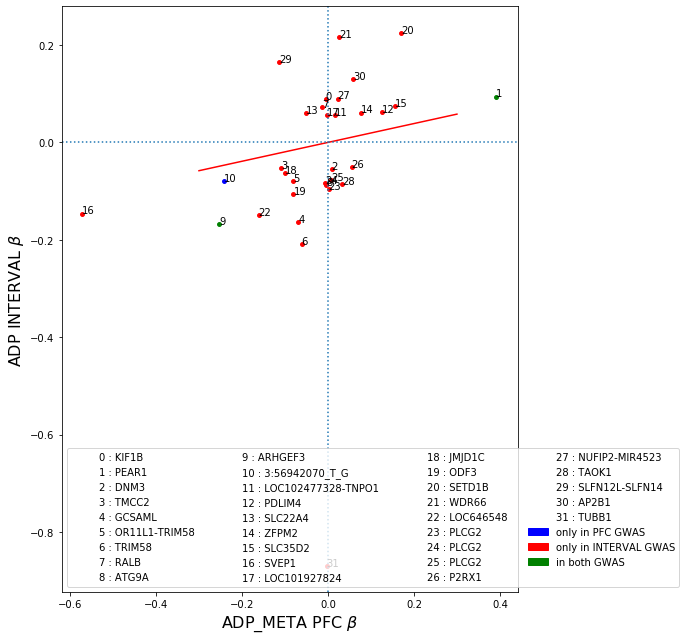

In [42]:
for pheno_pfc in ["ADP_META"]:
    
    pheno_hv = pheno_pfc.split("_")[0]
    df = pd.merge(gw.loc[gw.pheno == pheno_hv],
                  gw_pfc.loc[gw_pfc.pheno == pheno_pfc],
                  #left_on=("SNP"),
                  #right_on=("RSID"))
                  left_on=("CHR","BP"),right_on=("CHR","BP"))
    df = df.loc[df.ALLELE1 == df.REF]

    plt.figure(figsize=(9,9))
    PFC_threshold = 7.3
    cond_only_PFC = (df.MLOG10P >= PFC_threshold) & ~df.RSID.isin(significant_HV)
    cond_only_HV = (df.MLOG10P < PFC_threshold) & df.RSID.isin(significant_HV)
    cond_both = (df.MLOG10P >= PFC_threshold) & df.RSID.isin(significant_HV)
    
    df.loc[df.ALT_MINOR,"BETA_y"] *= -1

    plt.scatter(df.loc[cond_only_PFC,"BETA_y"],df.loc[cond_only_PFC,"BETA_x"],c="blue",s=15)
    plt.scatter(df.loc[cond_only_HV ,"BETA_y"],df.loc[cond_only_HV ,"BETA_x"],c="red",s=15)
    plt.scatter(df.loc[cond_both    ,"BETA_y"],df.loc[cond_both    ,"BETA_x"],c="green",s=15)

    plotted_rsIDs = df.loc[cond_only_PFC | cond_only_HV | cond_both,"RSID"].unique().tolist()
    
    
    ID_gene = {}
    legend_elements = []
    for i, SNP in enumerate(plotted_rsIDs):
        row = df.loc[df.RSID == SNP].iloc[0]
        x = row["BETA_y"]
        y = row["BETA_x"]
        plt.text(x,y,"%d" % i)
        try:
            ID_gene[i] = recap.loc[SNP,"genes"]
        except:
            ID_gene[i] = row["ID"]
        legend_elements.append(Patch(facecolor='white', edgecolor='white',
                         label='%d : %s' % (i,ID_gene[i])))
    legend_elements.append(Patch(facecolor='blue', edgecolor='blue',
                         label='only in PFC GWAS'))
    legend_elements.append(Patch(facecolor='red', edgecolor='red',
                         label='only in INTERVAL GWAS'))
    legend_elements.append(Patch(facecolor='green', edgecolor='green',
                         label='in both GWAS'))
    plt.legend(handles=legend_elements,ncol=4)

    plt.plot([-.3,.3],np.sqrt(0.03)/np.sqrt(0.8)*np.array([-.3,.3]),c="red")
    #plt.xlim((-.5,.5))
    #plt.ylim((-.2,.2))
    plt.axvline(0,ls=":")
    plt.axhline(0,ls=":")
    plt.xlabel("%s PFC $\\beta$" % pheno_pfc,fontsize=16)
    plt.ylabel("%s INTERVAL $\\beta$" % pheno_hv,fontsize=16)
    plt.tight_layout()

In [49]:
df.loc[(cond_both | cond_only_PFC | cond_only_HV) & (df.CHR >= 20)]

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA_x,SE_x,...,MAF,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA_y,SE_y,MLOG10P,POS_y,pheno_y
6846734,rs415064,20,57597971,0,G,C,0.953224,0.002757,-0.869482,0.020385,...,0.04552,True,5242.0,250.0,1.0,-0.002972,0.09512,0.01096,2775020437,ADP_META


In [53]:
X = df.loc[(cond_both | cond_only_PFC | cond_only_HV)]
pearsonr(X["BETA_x"],X["BETA_y"])

(0.30464993786697325, 0.09000642946658945)

In [50]:
X = df.loc[(cond_both | cond_only_PFC | cond_only_HV) & (df.CHR < 20)]
pearsonr(X["BETA_x"],X["BETA_y"])

(0.5390753470427234, 0.0017531430942830314)

In [51]:
pearsonr(df["BETA_x"],df["BETA_y"])

(0.004160449485319816, 2.219573452610473e-28)

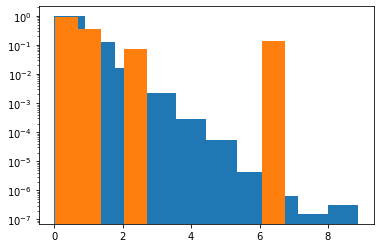

In [53]:
plt.hist(df.MLOG10P,density=True)
plt.hist(df.loc[cond_only_HV | cond_both,"MLOG10P"],density=True)
plt.yscale("log")

In [48]:
df.loc[cond_only_HV | cond_both].sort_values("MLOG10P",ascending=False)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA_x,SE_x,...,MAF,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA_y,SE_y,MLOG10P,POS_y,pheno_y
1321752,rs1354034,3,56849749,0,T,C,0.404720,0.007165,-0.030688,0.003405,...,0.395,False,1057.00,1689.00,1.0000,-0.236900,0.04538,6.74900,549273948,ADP_PAIR
309492,rs12566888,1,156869047,0,G,T,0.910466,0.003566,0.032780,0.005737,...,0.092,True,2501.00,245.00,1.0000,-0.398500,0.07836,6.43500,156869047,ADP_PAIR
1322009,rs13070800,3,56942973,0,C,T,0.370811,0.005282,0.019605,0.003410,...,0.368,False,1037.00,1709.00,1.0000,0.125600,0.04664,2.14900,549367172,ADP_PAIR
3901934,rs6993770,8,106581528,0,A,T,0.715747,0.006594,0.038363,0.003638,...,0.291,True,1976.00,770.00,1.0000,-0.101300,0.05046,1.35000,1498809462,ADP_PAIR
553310,rs10749636,1,248020448,0,G,A,0.235612,0.046659,0.025232,0.003957,...,0.246,False,668.05,2077.95,0.9730,-0.106400,0.05385,1.31700,248020448,ADP_PAIR
2537640,rs152039,5,122220665,0,G,A,0.331383,0.002254,-0.028763,0.003479,...,0.321,False,902.80,1843.20,0.9984,0.082610,0.04936,1.02600,1003588756,ADP_PAIR
6014275,rs16948306,15,65153223,0,A,C,0.839218,0.005315,-0.028091,0.004460,...,0.151,True,2312.60,433.40,0.9968,0.099320,0.06251,0.95050,2371495573,ADP_PAIR
2538114,rs17388251,5,122360403,0,T,C,0.617303,0.002994,0.020699,0.003371,...,0.367,True,1713.00,1033.00,1.0000,-0.063720,0.04770,0.74090,1003728494,ADP_PAIR
6014393,rs1625856,15,65195074,0,G,A,0.835455,0.006493,-0.030844,0.004425,...,0.150,True,2306.60,439.40,0.9987,0.071570,0.06289,0.59320,2371537424,ADP_PAIR
352172,rs6425522,1,171946082,0,T,C,0.193148,0.005753,0.026680,0.004173,...,0.199,False,553.85,2192.15,0.9838,-0.053620,0.05717,0.45800,171946082,ADP_PAIR
